### **1.1 Install Dependencies**

In [1]:
!pip install tensorflow opencv-python matplotlib

### **1.2 Import Dependencies**

In [2]:
# Import Standard Dependencies
import cv2   #import opencv
import os   #operating system library
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# import tensorflow dependencies- Functional API
# Model= allows you to define and structure your neural network.
# Layer= The base class for all layers in Keras.
# Conv2D= This layer performs 2D convolution
# Dense= Fully Connected Layer
# Flatten= All the previous information is flatten down. Pass CNN data to a dense network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense,MaxPooling2D, Input, Flatten
import tensorflow as tf

### **1.3 Set GPU Growth**

In [4]:
#Avoid Out of Memory error by setting GPY Memory consumption growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [5]:
gpus

[]

 ### **1.4 Create Folder Strcture**

In [6]:
#Positive Images: Pictures containing the specific object or face the model should recognize.
#Negative Images: Pictures containing anything other than the target object or face.
#Anchor Images: Reference images used for comparison to determine similarity with other images.

In [7]:
 #Setup paths
 POS_PATH= os.path.join('data','positive')
 NEG_PATH=os.path.join('data','negative')
 ANC_PATH=os.path.join('data','anchor')


In [8]:
# Make the directories
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

# **2. Collecting Positives and Anchors**

### **2.1 Labelled Dataset in the Wild Dataset is imported an moved to negative folder**

In [9]:
!pip install opendatasets

In [10]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jessicali9530/lfw-dataset")

Skipping, found downloaded files in ".\lfw-dataset" (use force=True to force download)


In [11]:
# Move LFW images to the following repistory data/ngative
#for directory in os.listdir('lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'):
#    for file in os.listdir(os.path.join('lfw-dataset/lfw-deepfunneled/lfw-deepfunneled', directory)):
#        EX_PATH= os.path.join('lfw-dataset/lfw-deepfunneled/lfw-deepfunneled',directory,file)
#        NEW_PATH= os.path.join(NEG_PATH,file)
#        os.replace(EX_PATH,NEW_PATH)

### **2.2 Collect Positive and Anchor Classes**

In [12]:
#Import uuid library to generate unique image names
import uuid

In [13]:
uuid.uuid1()

UUID('8f88f769-31f0-11f0-9b0d-c4236094bb01')

In [15]:
#Establish a connection to the webcam
cap=cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame=cap.read()

  #Cut down frame to 250x250px
  frame= frame[120:120+250,200:200+250, :]

  #Collect Anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
      #create the unique file path
      imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
      #write out the anchor image
      cv2.imwrite(imgname,frame)
 
  #Collect positives
  if cv2.waitKey(1) & 0XFF == ord('p'):
      #create the unique file path
      imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
      #write out the anchor image
      cv2.imwrite(imgname,frame)
  #Show image back to the screen
  cv2.imshow('Image Collection',frame)

  #Breaking Gracefully
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

#Relese the webcam
cap.release()
      
#Close the image show frame
cv2.destroyAllWindows()


# **3. Load and Preprocess Images**

### **3.1 Get Image Directories**

In [31]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)

In [32]:
dir_test=anchor.as_numpy_iterator()

In [67]:
print(dir_test.next())

b'data\\anchor\\a1bfdb0f-2a9a-11f0-9e83-005056c00008.jpg'


### **3.2 Preprocessing scale and resize**

In [34]:
def preprocess(file_path):

    #Read in image from file path
    byte_img = tf.io.read_file(file_path)

    #Load in the image
    img = tf.io.decode_jpeg(byte_img)

    #Preprocessing steps-resizing the image to be 100x100x3
    img = tf.image.resize(img,(100,100))
    
    #Scale image to be between 0 and 1
    img = img/255.0
    
    #Return image
    return img

In [73]:
preprocess('data\\anchor\\a1bfdb0f-2a9a-11f0-9e83-005056c00008.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.55196077, 0.5088235 , 0.3990196 ],
        [0.55710787, 0.5002451 , 0.40122548],
        [0.57892156, 0.51029414, 0.42303923],
        ...,
        [0.64730394, 0.61789215, 0.5482843 ],
        [0.65      , 0.61470586, 0.5480392 ],
        [0.6598039 , 0.6127451 , 0.55      ]],

       [[0.54632354, 0.5002451 , 0.39240196],
        [0.5637255 , 0.50514704, 0.40392157],
        [0.5862745 , 0.51593137, 0.41985294],
        ...,
        [0.6362745 , 0.6098039 , 0.5470588 ],
        [0.64215684, 0.6105392 , 0.55      ],
        [0.6392157 , 0.6039216 , 0.54509807]],

       [[0.5529412 , 0.49215686, 0.39313725],
        [0.5659314 , 0.49779412, 0.4002451 ],
        [0.595098  , 0.51960784, 0.41617647],
        ...,
        [0.6340686 , 0.61715686, 0.55808824],
        [0.6377451 , 0.6134804 , 0.5566176 ],
        [0.62941176, 0.59705883, 0.5441176 ]],

       ...,

       [[0.38235295, 0.30392158, 0.27009803],
        [0.40

In [74]:
img=preprocess('data\\anchor\\b5536902-2a9a-11f0-9271-005056c00008.jpg')

In [75]:
img.numpy().min()

np.float32(0.13014705)

In [76]:
img.numpy().max()

np.float32(0.92720586)

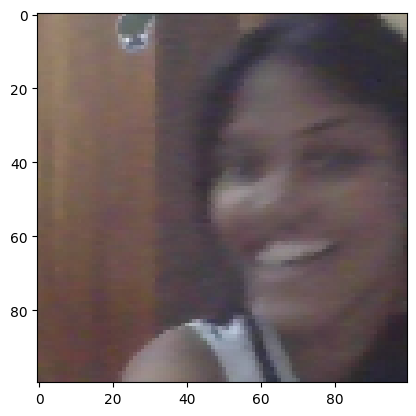

In [77]:
plt.imshow(img)

### **3.3 Create Labelled Dataset**

In [153]:
# (anchor,positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [154]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [155]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [156]:
samples = data.as_numpy_iterator()

In [157]:
exampple=samples.next()

In [158]:
exampple

(b'data\\anchor\\328c5bfd-2a9b-11f0-98ac-005056c00008.jpg',
 b'data\\positive\\c66b0c40-2a98-11f0-b3cf-005056c00008.jpg',
 np.float32(1.0))

### **3.3 Build Train and Test Partition**

In [159]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [160]:
 res =preprocess_twin(*exampple)

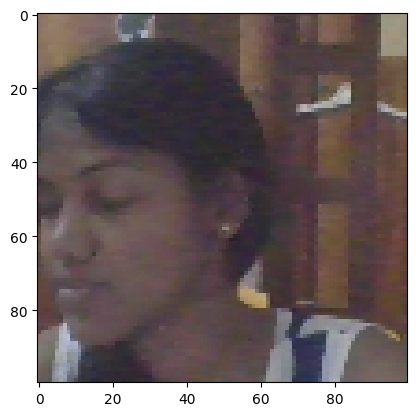

In [161]:
plt.imshow(res[0])


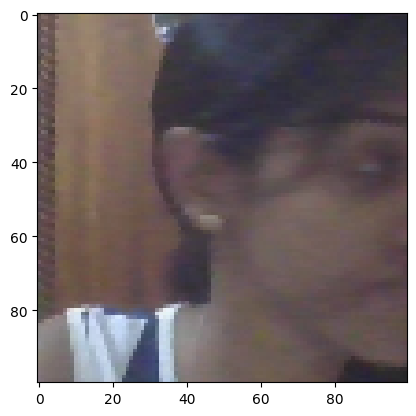

In [162]:
plt.imshow(res[1])

In [163]:
res[2]

np.float32(1.0)

In [164]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)


In [165]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [166]:
samples = data.as_numpy_iterator()

In [170]:
len(samples.next())

3

In [185]:
samp = samples.next()

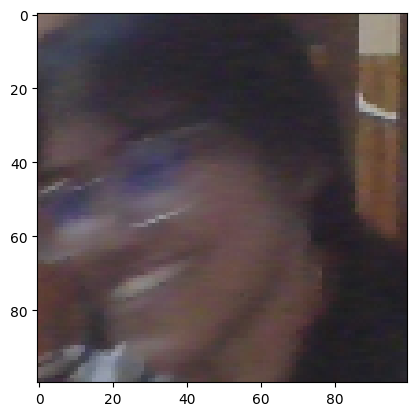

In [186]:
plt.imshow(samp[0])

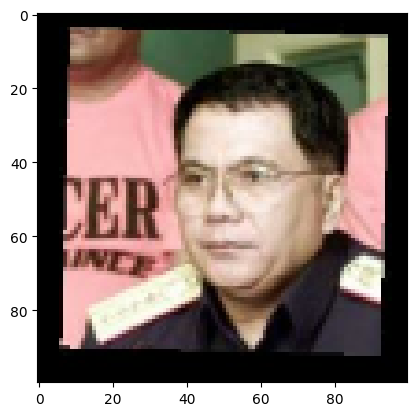

In [187]:
plt.imshow(samp[1])

In [188]:
samp[2]

np.float32(0.0)

In [189]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [190]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [191]:
train_samples = train_data.as_numpy_iterator()

In [192]:
train_sample = train_samples.next()

In [193]:
len(train_sample[0])

16

In [194]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### **4. Model Engineering**

### **4.1 Build Embedding Layer**

In [195]:
inp = Input(shape=(100,100,3), name='input_image')

In [196]:
inp

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=False, ragged=False, name=input_image>

In [197]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [198]:
c1

<KerasTensor shape=(None, 91, 91, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [199]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [200]:
m1

<KerasTensor shape=(None, 46, 46, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>

In [201]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [202]:
c2

<KerasTensor shape=(None, 40, 40, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>

In [203]:
m2

<KerasTensor shape=(None, 20, 20, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>

In [204]:
m2

<KerasTensor shape=(None, 20, 20, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>

In [205]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [206]:
c3

<KerasTensor shape=(None, 17, 17, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4>

In [207]:
m3

<KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>

In [208]:
m3

<KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>

In [209]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [210]:
c4

<KerasTensor shape=(None, 6, 6, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_6>

In [211]:
 f1

<KerasTensor shape=(None, 9216), dtype=float32, sparse=False, ragged=False, name=keras_tensor_7>

In [212]:
d1

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_8>

In [213]:
mod = Model(inputs=[inp], outputs=d1, name='embedding')

In [214]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [215]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=d1, name='embedding')

In [216]:
embedding = make_embedding()

In [217]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### **4.2 Build Distance Layer**

In [218]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [219]:
l1 = L1Dist()

### **4.3 Make Siamese Model**

In [220]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [221]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)


In [222]:
inp_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>

In [223]:
val_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_19>

In [224]:
siamese_layer = L1Dist()

In [225]:
siamese_layer(inp_embedding,val_embedding)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_20>

In [226]:
distances = siamese_layer(inp_embedding, val_embedding)


In [227]:
distances

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>

In [228]:
    classifier = Dense(1, activation='sigmoid')(distances)

In [229]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_22>

In [230]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [231]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[1][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [232]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [233]:
siamese_model = make_siamese_model()

In [234]:
siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# **5. Training**

### **5.1 Setup Loss and Optimizer**

In [235]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [236]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### **5.2 Establish Checkpoints**

In [237]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### **5.3 Build Train Step Function**

In [238]:
test_batch=train_data.as_numpy_iterator()

In [239]:
batch_1=test_batch.next()

In [240]:
x=batch_1[:2]

In [241]:
np.array(x).shape

(2, 16, 100, 100, 3)

In [242]:
y=batch_1[2]

In [243]:
y

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [244]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss


### **5.4 Build Training Loop**

In [245]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [246]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### **5.5 Train the model**

In [247]:
EPOCHS = 50

In [248]:
train(train_data, EPOCHS)


 Epoch 1/50


E:\Users\udith\Anaconda\envs\tf_env\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

E:\Users\udith\Anaconda\envs\tf_env\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(4, 100, 100, 3))
  warnings.warn(msg)


Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

 Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step


### **6. Evaluate Model**

### 6.1 Import Metrics

In [249]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### 6.2 Make Predictions

In [250]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [251]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[9.9999928e-01],
       [9.9999171e-01],
       [9.9991602e-01],
       [2.3524994e-07],
       [1.0558180e-05],
       [1.0000000e+00],
       [1.7182867e-09],
       [1.0000000e+00],
       [1.8190223e-05],
       [1.2588517e-07],
       [9.9970043e-01],
       [9.9972630e-01],
       [1.0000000e+00],
       [1.0682044e-07],
       [3.3981212e-07],
       [2.5906684e-06]], dtype=float32)

In [252]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]

In [253]:
y_true

array([1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

### 6.3 Calculate Metrics

In [254]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [255]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

### 6.4 Visualize Results

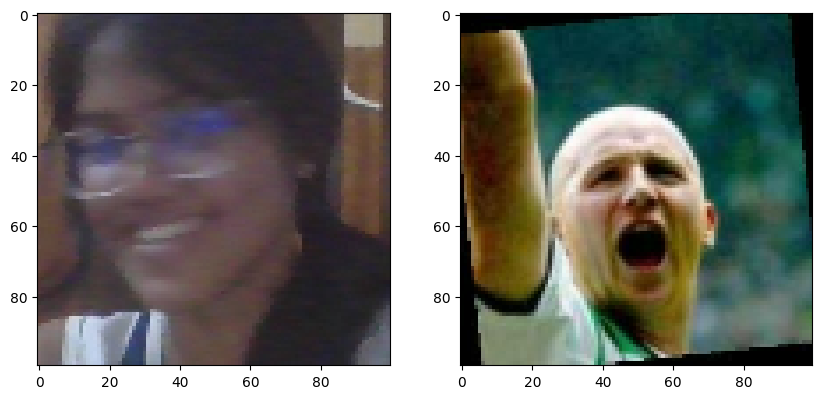

In [261]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# Renders cleanly
plt.show()

# 7. Save Model

In [262]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [263]:
L1Dist

__main__.L1Dist

In [264]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [265]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[9.9999928e-01],
       [9.9999171e-01],
       [9.9991602e-01],
       [2.3524994e-07],
       [1.0558180e-05],
       [1.0000000e+00],
       [1.7182867e-09],
       [1.0000000e+00],
       [1.8190223e-05],
       [1.2588517e-07],
       [9.9970043e-01],
       [9.9972630e-01],
       [1.0000000e+00],
       [1.0682044e-07],
       [3.3981212e-07],
       [2.5906684e-06]], dtype=float32)

In [266]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

### 8.1 Verification Function

application_data\verification_images

In [269]:
os.listdir(os.path.join('application_data', 'verification_images'))

['4accef46-2a99-11f0-9e60-005056c00008.jpg',
 '504a042e-2a99-11f0-ad8b-005056c00008.jpg',
 '550a7c5e-2a99-11f0-85fd-005056c00008.jpg',
 '5ae24471-2a99-11f0-aced-005056c00008.jpg',
 '5f95eb40-2a99-11f0-ab78-005056c00008.jpg',
 '5fb0aae4-2a99-11f0-96a2-005056c00008.jpg',
 '5ff36511-2a99-11f0-baf4-005056c00008.jpg',
 '6033db94-2a99-11f0-a981-005056c00008.jpg',
 '8188e00f-2a99-11f0-9f11-005056c00008.jpg',
 '88ae110f-2a99-11f0-9a26-005056c00008.jpg',
 '88ef3388-2a99-11f0-9199-005056c00008.jpg',
 '8953d3d7-2a99-11f0-b4c0-005056c00008.jpg',
 '8a78ea5f-2a99-11f0-9ac1-005056c00008.jpg',
 '8abb9deb-2a99-11f0-993b-005056c00008.jpg',
 '8ae1d5a0-2a98-11f0-a9a8-005056c00008.jpg',
 '8b2944f5-2a98-11f0-b5f5-005056c00008.jpg',
 '8b711eea-2a98-11f0-a115-005056c00008.jpg',
 '900be1f5-2a99-11f0-ade5-005056c00008.jpg',
 '909f87c4-2a99-11f0-b108-005056c00008.jpg',
 '91b4203c-2a99-11f0-bfe2-005056c00008.jpg',
 '91d08c9b-2a99-11f0-b631-005056c00008.jpg',
 '936a5807-2a98-11f0-ab61-005056c00008.jpg',
 '951af988

In [270]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [271]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\4accef46-2a99-11f0-9e60-005056c00008.jpg
application_data\verification_images\504a042e-2a99-11f0-ad8b-005056c00008.jpg
application_data\verification_images\550a7c5e-2a99-11f0-85fd-005056c00008.jpg
application_data\verification_images\5ae24471-2a99-11f0-aced-005056c00008.jpg
application_data\verification_images\5f95eb40-2a99-11f0-ab78-005056c00008.jpg
application_data\verification_images\5fb0aae4-2a99-11f0-96a2-005056c00008.jpg
application_data\verification_images\5ff36511-2a99-11f0-baf4-005056c00008.jpg
application_data\verification_images\6033db94-2a99-11f0-a981-005056c00008.jpg
application_data\verification_images\8188e00f-2a99-11f0-9f11-005056c00008.jpg
application_data\verification_images\88ae110f-2a99-11f0-9a26-005056c00008.jpg
application_data\verification_images\88ef3388-2a99-11f0-9199-005056c00008.jpg
application_data\verification_images\8953d3d7-2a99-11f0-b4c0-005056c00008.jpg
application_data\verification_images\8a78ea5f-2a99-11f0-9ac1-005

In [272]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time Verification

In [275]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [276]:
np.sum(np.squeeze(results) > 0.9)

np.int64(49)